In [57]:
import pandas as pd
import json
import numpy as np

In [58]:
df_w1 = pd.read_csv("Raw/W1_AllAppsWide_2024-11-13-4.csv")
df_w1 = df_w1.query('`session.code` == "3m87qmko" | `session.code` == "wt9ndgb1"')
# Fix the missing label
df_w1.loc[df_w1["network_app.1.player.participantcode"] == "tfp", "network_app.1.player.participantcode"] = "tpf"

df_w2 = pd.read_csv("Raw/W2_all_apps_wide_2024-12-10-2.csv")
df_w2 = df_w2.query('`session.code` == "2n8orvug"')
df_w2["participant.label"][244] = "nan" # fixing the missing label

df_w3 = pd.read_csv("Raw/W3_all_apps_wide_2025-01-29.csv")
df_w3 = df_w3.query('`session.code` == "7uy8unkt"')
df_w3["participant.label"][46] = "nan" # fixing the missing label

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_69198/1169033480.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_w2["participant.label"][244] = "nan" # fixing the missing label
/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn

In [59]:
df_w2

,participant.id_in_session,participant.code,participant.label,participant._is_bot,participant._index_in_pages,participant._max_page_index,participant._current_app_name,participant._current_page_name,participant.time_started_utc,participant.visited,...,end_app.1.player.role,end_app.1.player.payoff,end_app.1.player.group_assignment,end_app.1.player.rnumber,end_app.1.player.rnumbercheck,end_app.1.player.feedback,end_app.1.player.time_firstendpage,end_app.1.player.time_endpage,end_app.1.group.id_in_subsession,end_app.1.subsession.round_number
115,1,84okfjny,ddh,0,21,21,end_app,End,2024-12-10 14:26:13.717993,1,...,NaN,0.0,1,145701,145701.0,Shikano ist richtig sweet.,2024-12-10T14:53:07.343Z,-999,1,1
116,2,3ewltlvd,evh,0,21,21,end_app,End,2024-12-10 14:26:22.940875,1,...,NaN,0.0,1,843370,843370.0,NaN,2024-12-10T14:46:29.254Z,-999,1,1
117,3,c4upbpk6,bs3,0,21,21,end_app,End,2024-12-10 14:26:23.789402,1,...,NaN,0.0,2,516998,516998.0,NaN,2024-12-10T14:49:12.511Z,-999,1,1
118,4,8oe49gr2,k4w,0,21,21,end_app,End,2024-12-10 14:26:24.290600,1,...,NaN,0.0,1,845841,845841.0,NaN,2024-12-10T14:47:16.827Z,-999,1,1
119,5,vxaikncq,39b,0,21,21,end_app,End,2024-12-10 14:26:26.451493,1,...,NaN,0.0,2,974915,974915.0,NaN,2024-12-10T14:48:57.760Z,-999,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,396,2ktq16ck,NaN,0,0,21,NaN,NaN,NaN,0,...,NaN,0.0,1,580979,NaN,NaN,-999,-999,1,1
511,397,97zzqsc7,NaN,0,0,21,NaN,NaN,NaN,0,...,NaN,0.0,2,866258,NaN,NaN,-999,-999,1,1
512,398,aa7g5870,NaN,0,0,21,NaN,NaN,NaN,0,...,NaN,0.0,1,505817,NaN,NaN,-999,-999,1,1
513,399,e9hjdo0n,NaN,0,0,21,NaN,NaN,NaN,0,...,NaN,0.0,2,711880,NaN,NaN,-999,-999,1,1


In [60]:
def prep_function_w1(df):
    # Drop rows where 'network_app.1.player.participantcode' is NaN
    df = df.dropna(subset=['network_app.1.player.participantcode'])
    # Lowercase the 'network_app.1.player.participantcode' column
    df['network_app.1.player.participantcode'] = df['network_app.1.player.participantcode'].str.lower()


    # Identify duplicates based on 'network_app.1.player.participantcode'
    duplicates = df[df.duplicated(subset='network_app.1.player.participantcode', keep=False)]
    # Filter duplicates where 'participant._index_in_pages' > 15
    filtered_duplicates = duplicates[duplicates['participant._index_in_pages'] > 15]
    # Remove the duplicates from the original dataframe (only those where 'participantcode' is duplicated)
    df = df[~df['network_app.1.player.participantcode'].isin(duplicates['network_app.1.player.participantcode'])]
    # Concatenate the filtered duplicates back into the dataframe
    df = pd.concat([df, filtered_duplicates], axis=0, ignore_index=True)


    # Lowercase person columns ('network_app.1.player.person_1' to 'network_app.1.player.person_30')
    person_columns = [f'network_app.1.player.person_{i}' for i in range(1, 31)]
    df[person_columns] = df[person_columns].apply(lambda x: x.str.lower())
    # Replace missing values with 'x' in all person columns
    df[person_columns] = df[person_columns].fillna("x")

    for _, row in df.iterrows():
        # Other node and edge processing...
        # Check if participantcode and person_1 match
        if row["network_app.1.player.participantcode"] == row["network_app.1.player.person_1"]:
            df.loc[_, "network_app.1.player.linksrechts_self"] = row["network_app.1.player.linksrechts_1"]

    df['participant.label'] = df['network_app.1.player.participantcode']

    return df


In [61]:
def prep_function_w2(df):
    df = df.dropna(subset=['participant.label'])
    
    for i in range(1, 31):
        df[f'network_app.1.player.person_{i}'] = df[f'network_app.1.player.person_{i}'].str.lower()

    df['network_app.1.player.person_3'] = df['network_app.1.player.person_3'].str.replace("ny4", "ny3", case=False, regex=False) #added because of commentary

    # Replace missing values with "x" in columns: 'network_app.1.player.person_1', 'network_app.1.player.person_2' and 28 other columns
    df = df.fillna({'network_app.1.player.person_1': "x", 'network_app.1.player.person_2': "x", 'network_app.1.player.person_3': "x", 'network_app.1.player.person_4': "x", 'network_app.1.player.person_5': "x", 'network_app.1.player.person_6': "x", 'network_app.1.player.person_7': "x", 'network_app.1.player.person_8': "x", 'network_app.1.player.person_9': "x", 'network_app.1.player.person_10': "x", 'network_app.1.player.person_11': "x", 'network_app.1.player.person_12': "x", 'network_app.1.player.person_13': "x", 'network_app.1.player.person_14': "x", 'network_app.1.player.person_15': "x", 'network_app.1.player.person_16': "x", 'network_app.1.player.person_17': "x", 'network_app.1.player.person_18': "x", 'network_app.1.player.person_19': "x", 'network_app.1.player.person_20': "x", 'network_app.1.player.person_21': "x", 'network_app.1.player.person_22': "x", 'network_app.1.player.person_23': "x", 'network_app.1.player.person_24': "x", 'network_app.1.player.person_25': "x", 'network_app.1.player.person_26': "x", 'network_app.1.player.person_27': "x", 'network_app.1.player.person_28': "x", 'network_app.1.player.person_29': "x", 'network_app.1.player.person_30': "x"})

    return df

In [62]:
def prep_function_w3(df):
    df = df.dropna(subset=['participant.label'])
    
    for i in range(1, 31):
        df[f'network_app.1.player.person_{i}'] = df[f'network_app.1.player.person_{i}'].str.lower()

    df['network_app.1.player.person_3'] = df['network_app.1.player.person_3'].str.replace("ny4", "ny3", case=False, regex=False) #added because of commentary

    # Replace missing values with "x" in columns: 'network_app.1.player.person_1', 'network_app.1.player.person_2' and 28 other columns
    df = df.fillna({'network_app.1.player.person_1': "x", 'network_app.1.player.person_2': "x", 'network_app.1.player.person_3': "x", 'network_app.1.player.person_4': "x", 'network_app.1.player.person_5': "x", 'network_app.1.player.person_6': "x", 'network_app.1.player.person_7': "x", 'network_app.1.player.person_8': "x", 'network_app.1.player.person_9': "x", 'network_app.1.player.person_10': "x", 'network_app.1.player.person_11': "x", 'network_app.1.player.person_12': "x", 'network_app.1.player.person_13': "x", 'network_app.1.player.person_14': "x", 'network_app.1.player.person_15': "x", 'network_app.1.player.person_16': "x", 'network_app.1.player.person_17': "x", 'network_app.1.player.person_18': "x", 'network_app.1.player.person_19': "x", 'network_app.1.player.person_20': "x", 'network_app.1.player.person_21': "x", 'network_app.1.player.person_22': "x", 'network_app.1.player.person_23': "x", 'network_app.1.player.person_24': "x", 'network_app.1.player.person_25': "x", 'network_app.1.player.person_26': "x", 'network_app.1.player.person_27': "x", 'network_app.1.player.person_28': "x", 'network_app.1.player.person_29': "x", 'network_app.1.player.person_30': "x"})

    return df

In [63]:
df_w1 = prep_function_w1(df_w1)
df_w2 = prep_function_w2(df_w2)
df_w3 = prep_function_w3(df_w3)

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_69198/32931137.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['network_app.1.player.participantcode'] = df['network_app.1.player.participantcode'].str.lower()
/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_69198/564018429.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'network_app.1.player.person_{i}'] = df[f'network_app.1.player.person_{i}'].str.lower()
/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_69198/56

In [66]:
def shiny_dataframe(df):
    """
    Preprocesses the input DataFrame by performing column drops and replacing missing values.

    Args:
        df (pd.DataFrame): The input DataFrame to preprocess.

    Returns:
        pd.DataFrame: The preprocessed DataFrame.
    """
    # Columns to drop
    drop_columns = [
        'participant._is_bot', 
        'participant._index_in_pages', 
        'conjoint_app.1.player.participant_label', 
        'conjoint_app.1.player.id_in_group',
        'participant._current_app_name', 
        'participant._current_page_name', 
        'conjoint_app.1.player.payoff', 
        'demographic_app.1.player.id_in_group',
        'participant.visited', 
        'participant.mturk_worker_id', 
        'participant.mturk_assignment_id',
        'participant.payoff', 
        'session.label', 
        'session.mturk_HITId', 
        'session.mturk_HITGroupId',
        'session.comment', 
        'session.is_demo', 
        'session.config.real_world_currency_per_point',
        'session.config.participation_fee', 
        'conjoint_app.1.player.language',
        'conjoint_app.1.group.id_in_subsession', 
        'conjoint_app.1.subsession.round_number',
        'demographic_app.1.player.role', 
        'demographic_app.1.player.payoff',
        'network_app.1.player.role', 
        'network_app.1.player.payoff',
        'demographic_app.1.group.id_in_subsession', 
        'demographic_app.1.subsession.round_number',
        'conjoint_app.1.player.role', 
        'session.config.name',
        'network_app.1.group.id_in_subsession', 
        'network_app.1.subsession.round_number',
        'political_app.1.player.role', 
        'political_app.1.player.id_in_group',
        'political_app.1.subsession.round_number', 
        'political_app.1.group.id_in_subsession',
        'end_app.1.player.role', 
        'end_app.1.player.payoff', 'end_app.1.player.group_assignment',
        'end_app.1.player.time_endpage', 'end_app.1.group.id_in_subsession',
        'end_app.1.subsession.round_number', 'political_app.1.player.payoff',
        'demographic_app.1.player.role',
        'end_app.1.player.rnumber',
        'end_app.1.player.rnumbercheck',
        'conjoint_app.1.player.time_start',
        'network_app.1.player.participantcode',
    ]

    # Columns with missing values to replace
    fill_values_zero = {
        'demographic_app.1.player.rent': -999,
        'demographic_app.1.player.income': -999,
        'participant.label': 0,
        'political_app.1.player.sunday_poll': 0,
        'political_app.1.player.sunday_party_vote': 0,
        'political_app.1.player.sunday_not_eligible': 0,
        'political_app.1.player.noteligible_sunday_party_vote': 0,
        'demographic_app.1.player.social_networks_1': 0,
        'demographic_app.1.player.social_networks_2': 0,
        'demographic_app.1.player.social_networks_3': 0,
        'demographic_app.1.player.social_networks_4': 0,
        'demographic_app.1.player.social_networks_5': 0,
        'demographic_app.1.player.social_networks_6': 0,
        'demographic_app.1.player.social_networks_7': 0,
        'demographic_app.1.player.social_networks_8': 0,
        'demographic_app.1.player.social_networks_9': 0,
        'demographic_app.1.player.social_networks_10': 0,
        'demographic_app.1.player.participation_demonstration_1': 0,
        'demographic_app.1.player.petition_signatory_1': 0,
        'conjoint_app.1.player.participant_label': 0,
        'network_app.1.player.participantcode': 0,
        'political_app.1.player.reason_no_vote': 0,
        'demographic_app.1.player.fresherscamp_student': 0,
        'demographic_app.1.player.freshersweek_student': 0,
        'demographic_app.1.player.school_father': 0,
        'demographic_app.1.player.consecutive_study_program': 0,
        'end_app.1.player.catdog': 0,
        'demographic_app.1.player.work_edu_father': 0,
    }

    fill_values_string_zero = {
        'demographic_app.1.player.social_networks_11': "0",
        'demographic_app.1.player.study_program_other': "0"
    }

    fill_values_negative = {
        'political_app.1.player.scalo_cdu': -999,
        'political_app.1.player.scalo_csu': -999,
        'political_app.1.player.scalo_spd': -999,
        'political_app.1.player.scalo_gruene': -999,
        'political_app.1.player.scalo_fdp': -999,
        'political_app.1.player.scalo_afd': -999,
        'political_app.1.player.scalo_linke': -999,
        'political_app.1.player.scalo_bsw': -999,
        'demographic_app.1.player.edu_mother': -999,
        'demographic_app.1.player.study_program': -999
    }

    # Drop specified columns
    df = df.drop(columns=[col for col in drop_columns if col in df.columns])

    # Replace missing values with 0
    df = df.fillna({col: val for col, val in fill_values_zero.items() if col in df.columns})

    # Replace missing values with "0"
    df = df.fillna({col: val for col, val in fill_values_string_zero.items() if col in df.columns})

    # Replace missing values with -999
    df = df.fillna({col: val for col, val in fill_values_negative.items() if col in df.columns})

    # Inconsistency in no answer variable
    df = df.replace(-888, -999)

    # List of prefixes to keep
    prefixes = ['conjoint', 
                'demographic', 
                'political', 
                'vignette', 
                'participant.label', 
                'network_app.1.player.participantcode',
                'network_app.1.player.linksrechts_self',
                #'network_app.1.player.person',
                'end_app.1.player.catdog',
                'end_app.1.player.rnumber']

    # Filter columns by prefixes
    df = df.loc[:, df.columns.str.startswith(tuple(prefixes))]

    return df

In [67]:
df_filtered_w1 = shiny_dataframe(df_w1)
df_filtered_w2 = shiny_dataframe(df_w2)
df_filtered_w3 = shiny_dataframe(df_w3)

# Export dataframes as CSV
df_filtered_w1.to_csv('Cooked/df_w1_prepared.csv', index=False)
df_filtered_w2.to_csv('Cooked/df_w2_prepared.csv', index=False)
df_filtered_w3.to_csv('Cooked/df_w3_prepared.csv', index=False)

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_69198/4220907679.py:114: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna({col: val for col, val in fill_values_zero.items() if col in df.columns})


***

## Merging Waves for Complete Dataframe

In [12]:
merged_df = pd.merge(
    df_filtered_w1,
    df_filtered_w2,
    how='outer',
    on="participant.label",
    suffixes=('_W1', '_W2')
)

# Rename columns in df_filtered_w3
df_filtered_w3 = df_filtered_w3.rename(columns=lambda x: f"{x}_W3" if x != "participant.label" else x)

# Merge without suffixes
merged_df = pd.merge(
    merged_df,
    df_filtered_w3,
    how='outer',
    on="participant.label"
)

In [13]:
complete_df = merged_df.sort_index(axis=1)

#complete_df.set_index('participant.label', inplace=True)

complete_df = complete_df.drop(columns=['demographic_app.1.player.rent_W1','demographic_app.1.player.income_W1',])

In [14]:
# Get all unique participants across all DataFrames
all_participants = set(df_w1['participant.label']) | set(df_w2['participant.label']) | set(df_w3['participant.label'])

# Get participants present in all three DataFrames (intersection)
complete = set(df_w1['participant.label']) & set(df_w2['participant.label']) & set(df_w3['participant.label'])

# Find the participants that are in at least one DataFrame but NOT in all three
difference = all_participants - complete

# Filter the original DataFrames to get only rows that contain these "difference" participants
df_w1_diff = df_w1[df_w1['participant.label'].isin(difference)]
df_w2_diff = df_w2[df_w2['participant.label'].isin(difference)]
df_w3_diff = df_w3[df_w3['participant.label'].isin(difference)]

# Filter the DataFrames to keep only the matching rows
df_w1_filtered = df_w1[df_w1['participant.label'].isin(complete)]
df_w2_filtered = df_w2[df_w2['participant.label'].isin(complete)]
df_w3_filtered = df_w3[df_w3['participant.label'].isin(complete)]

df_diff = pd.merge(
    df_w1_diff,
    df_w2_diff,
    how='outer',
    on="participant.label",
    suffixes=('_W1', '_W2')
)

# Rename columns in df_filtered_w3
df_w3_diff = df_w3_diff.rename(columns=lambda x: f"{x}_W3" if x != "participant.label" else x)

# Merge without suffixes
df_diff = pd.merge(
    df_diff,
    df_w3_diff,
    how='outer',
    on="participant.label"
)

In [15]:
x = set(df_w1_diff['participant.label']) & set(df_w2_diff['participant.label'])
y = set(df_w2_diff['participant.label']) & set(df_w3_diff['participant.label'])
z = set(df_w1_diff['participant.label']) & set(df_w3_diff['participant.label'])

comp = set(df_w1_diff['participant.label']) | set(df_w3_diff['participant.label']) | set(df_w2_diff['participant.label'])

singles = comp - x - y - z 

w2_w3_df = df_diff[df_diff['participant.label'].isin(y)]
singles_df = df_diff[df_diff['participant.label'].isin(singles)]
singles_df.sort_index(axis=1, inplace=True)
w2_w3_df.sort_index(axis=1, inplace=True)

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_69198/294661306.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  singles_df.sort_index(axis=1, inplace=True)
/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_69198/294661306.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w2_w3_df.sort_index(axis=1, inplace=True)


In [16]:
complete_complete_df = complete_df[complete_df['participant.label'].isin(complete)]
complete_complete_df.sort_index(axis=1, inplace=True)
complete_complete_df.set_index('participant.label', inplace=True)
#complete_complete_df.replace(-999, np.nan, inplace=True)

Filling the different waves with information from other waves

In [17]:
# List of suffixes for waves
suffixes = ['_W1', '_W2', '_W3']

# Iterate over suffixes and fill missing values
for i in range(len(suffixes) - 1):
    current_suffix = suffixes[i]  # e.g., '_W1' or '_W2'
    next_suffix = suffixes[i + 1]  # e.g., '_W2' or '_W3'

    # Get columns for the current wave
    current_columns = [col for col in complete_complete_df.columns if col.endswith(current_suffix)]

    # For each column in the current wave, check if the corresponding column exists in the next wave
    for current_col in current_columns:
        next_col = current_col.replace(current_suffix, next_suffix)

        # Fill missing values in the current wave column with values from the next wave column
        if next_col in complete_complete_df.columns:
            complete_complete_df[current_col] = complete_complete_df[current_col].fillna(complete_complete_df[next_col])

        # Fill missing values in the next wave column with values from the current wave column
        if current_col in complete_complete_df.columns and next_col in complete_complete_df.columns:
            complete_complete_df[next_col] = complete_complete_df[next_col].fillna(complete_complete_df[current_col])


/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_69198/275464716.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_complete_df[current_col] = complete_complete_df[current_col].fillna(complete_complete_df[next_col])
/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_69198/275464716.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_complete_df[next_col] = complete_complete_df[next_col].fillna(complete_complete_df[current_col])


In [18]:
def split_df_by_suffix(df, suffix):
    # Filter columns that end with the specified suffix
    columns = [col for col in df.columns if col.endswith(suffix)]
    
    # Create a subset DataFrame with the filtered columns
    subset_df = df[columns]
    
    # Remove the suffix from the column names
    subset_df.columns = [col.replace(suffix, '') for col in subset_df.columns]
    
    return subset_df

# Example usage
df_1 = split_df_by_suffix(complete_complete_df, '_W1')
df_2 = split_df_by_suffix(complete_complete_df, '_W2')
df_3 = split_df_by_suffix(complete_complete_df, '_W3')

An interesting idea would be two create new variables from multiple columns in the survey. 
- Popularity of political people 
- Socialmedia apps 
- 

***
## Network Dictionaries
`dict_nodes = {participant_label : {participant_attributes : values, network_app.1.player.person_1...30 : {Friends : True, Politics : True}}}`

In [19]:
def replace_missing_with_default(value, default_value=-999):
    if pd.isna(value) or value in [""]:
        return default_value
    return value

def create_nodes(df, unique_id, wave):
    # Initialize nodes with empty dictionaries
    dict_nodes = {label: {} for label in df[unique_id]}

    # Iterate through rows to populate node attributes
    for _, row in df.iterrows():
        label = row[unique_id]
        if label in dict_nodes:
            # Add all columns to the dictionary
            for column in df.columns:
                # Skip the unique_id column to avoid redundancy
                if column == unique_id:
                    continue
                # Extract the part after the last dot
                key = column.split('.')[-1]
                # Remove the underscore and everything after it
                #key = key.split('_')[0]
                # Use the simplified key and replace missing values
                dict_nodes[label][key] = replace_missing_with_default(row[column])

    return dict_nodes

In [20]:
def create_edges(df, unique_id, dict_nodes):
    dict_edges = {label: {} for label in df[unique_id]}
    dropped = 0
    list_dropped = []
    edge_info = {
        "friend": 0,
        "value": 0,
        "politics": 0,
        "study": 0,
        "council": 0,
        "leftright": 0,
        "sentiment": 0,
        "aquaintance": 0
    }

    # Iterate through rows to populate edge attributes
    for _, row in df.iterrows():
        label = row[unique_id]
        for i in range(1, 30):
            target_person = row[f"network_app.1.player.person_{i}"]
            if target_person != "x" and target_person != label:
                if target_person in dict_nodes:
                    dict_edges[label][target_person] = {
                        "aquaintance": True,
                        "friend": replace_missing_with_default(row[f"network_app.1.player.friend_{i}"]) == 1,
                        "value": replace_missing_with_default(row[f"network_app.1.player.value_{i}"]) == 1,
                        "politics": replace_missing_with_default(row[f"network_app.1.player.politics_{i}"]) == 1,
                        "study": replace_missing_with_default(row[f"network_app.1.player.study_{i}"]) == 1,
                        "council": replace_missing_with_default(row[f"network_app.1.player.council_{i}"]) == 1,
                        "leftright": replace_missing_with_default(row[f"network_app.1.player.linksrechts_{i}"])
                    }
                    try:
                        dict_edges[label][target_person]["sentiment"] = replace_missing_with_default(row[f"network_app.1.player.sentiment_{i}"])
                    except KeyError:
                        pass

                    # Update edge information counts
                    edge_info["friend"] += dict_edges[label][target_person]["friend"]
                    edge_info["value"] += dict_edges[label][target_person]["value"]
                    edge_info["politics"] += dict_edges[label][target_person]["politics"]
                    edge_info["study"] += dict_edges[label][target_person]["study"]
                    edge_info["council"] += dict_edges[label][target_person]["council"]
                    edge_info["leftright"] += 1  # Assuming each edge has a leftright value
                    if "sentiment" in dict_edges[label][target_person]:
                        edge_info["sentiment"] += 1
                else:
                    # Log dropped connections
                    dropped += 1
                    list_dropped.append(target_person)

    return dict_edges, edge_info, list_dropped

In [21]:
def data_extraction(df_nodes, df_edges, unique_id, wave):
    # Create nodes
    dict_nodes = create_nodes(df_nodes, unique_id, wave)
    
    # Create edges
    dict_edges, edge_info, list_dropped = create_edges(df_edges, unique_id, dict_nodes)

    # Save nodes and edges to JSON files
    with open(f'NA/nodes_{wave}.json', 'w') as json_file:
        json.dump(dict_nodes, json_file, indent=4)

    with open(f'NA/edges_{wave}.json', 'w') as json_file:
        json.dump(dict_edges, json_file, indent=4)

    # Print edge information summary
    print(f"Edge information for wave {wave}:")
    for key, value in edge_info.items():
        print(f"{key}: {value}")

    sum_edges = sum(len(edges) for edges in dict_edges.values())
    print("Amount of Edges dropped:", len(list_dropped))

    return dict_nodes, dict_edges, list_dropped

In [22]:
df_1 = df_1.reset_index()
df_2 = df_2.reset_index()
df_3 = df_3.reset_index()

dict_nodes_w1, dict_edges_w1, list_dropped_w1 = data_extraction(df_1, df_w1_filtered ,'participant.label', "W1")
dict_nodes_w2, dict_edges_w2, list_dropped_w2 = data_extraction(df_2, df_w2_filtered, "participant.label", "W2")
dict_nodes_w3, dict_edges_w3, list_dropped_w3 = data_extraction(df_3, df_w3_filtered, "participant.label", "W3")

Edge information for wave W1:
friend: 338
value: 253
politics: 228
study: 260
council: 327
leftright: 599
sentiment: 0
aquaintance: 0
Amount of Edges dropped: 79
Edge information for wave W2:
friend: 361
value: 235
politics: 210
study: 187
council: 317
leftright: 589
sentiment: 589
aquaintance: 0
Amount of Edges dropped: 88
Edge information for wave W3:
friend: 352
value: 262
politics: 219
study: 195
council: 338
leftright: 601
sentiment: 601
aquaintance: 0
Amount of Edges dropped: 53


In [23]:
df_1["net"]

,participant.label,conjoint_app.1.player.browser,conjoint_app.1.player.device_type,conjoint_app.1.player.lang,conjoint_app.1.player.operating_system,conjoint_app.1.player.use_of_device,demographic_app.1.player.age,demographic_app.1.player.edu_father,demographic_app.1.player.edu_mother,demographic_app.1.player.gender,...,political_app.1.player.scalo_pep4,political_app.1.player.scalo_pep5,political_app.1.player.scalo_pep6,political_app.1.player.scalo_pep7,political_app.1.player.scalo_pep8,political_app.1.player.scalo_pep9,political_app.1.player.scalo_spd,political_app.1.player.sunday_not_eligible,political_app.1.player.sunday_party_vote,political_app.1.player.sunday_poll
0,39b,3.0,2.0,0.0,5.0,1.0,18.0,2.0,2.0,1.0,...,-3.0,-4.0,2.0,-4.0,1.0,-1.0,3.0,0.0,3.0,1.0
1,3ab,3.0,3.0,0.0,2.0,1.0,20.0,4.0,4.0,2.0,...,-1.0,-1.0,0.0,-5.0,3.0,2.0,3.0,0.0,1.0,1.0
2,3eh,5.0,3.0,0.0,1.0,1.0,20.0,2.0,3.0,2.0,...,-1.0,-3.0,0.0,-3.0,1.0,-3.0,3.0,0.0,1.0,1.0
3,3fv,3.0,2.0,0.0,5.0,2.0,19.0,2.0,2.0,1.0,...,-2.0,-4.0,0.0,-5.0,-3.0,-3.0,2.0,0.0,3.0,1.0
4,3hc,3.0,3.0,0.0,2.0,1.0,24.0,3.0,3.0,1.0,...,0.0,-2.0,1.0,-5.0,5.0,2.0,3.0,0.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,yg9,3.0,3.0,0.0,3.0,2.0,19.0,1.0,1.0,1.0,...,-4.0,-5.0,-5.0,-5.0,0.0,0.0,-4.0,0.0,7.0,1.0
150,yqq,3.0,3.0,0.0,2.0,2.0,20.0,4.0,3.0,1.0,...,-1.0,0.0,-1.0,-3.0,3.0,3.0,4.0,0.0,1.0,1.0
151,ytr,3.0,3.0,0.0,2.0,2.0,19.0,4.0,4.0,2.0,...,3.0,2.0,0.0,3.0,-4.0,-5.0,-4.0,0.0,6.0,1.0
152,yuc,3.0,3.0,0.0,2.0,1.0,19.0,4.0,4.0,1.0,...,-2.0,-5.0,1.0,-5.0,3.0,0.0,0.0,0.0,3.0,1.0


***


## Political-Assessment Ego and Alter 

- scale only ranged form 1 to 11 
- "0" values are missings!

In [431]:
def political_identity(df):
    dict_political_identity = {}

    for index, row in df.iterrows():
        participant_id = row['participant.label']
        self_identity = row.get('network_app.1.player.linksrechts_self')

        # If self_identity is 0 or NaN, set to NaN
        if pd.isna(self_identity) or self_identity == 0:
            self_identity = float('nan')
        
        dict_political_identity[participant_id] = {
            'ego': self_identity,
            'alter_mean': float('nan'),
            'delta_ego_alter': float('nan'),
            'abs_delta_ego_alter': float('nan'),
            'alter': []
        }

        for i in range(1, 30):
            other_identity = row.get(f'network_app.1.player.linksrechts_{i}')
            if pd.notna(other_identity) and other_identity != 0:
                dict_political_identity[participant_id]['alter'].append(other_identity)

    for participant_id, data in dict_political_identity.items():
        if data['alter'] and not pd.isna(data['ego']):
            data['alter_mean'] = round(np.mean(data['alter']),3)
            data['delta_ego_alter'] = round(data['ego'] - data['alter_mean'],3)
            data['abs_delta_ego_alter'] = abs(round(data['ego'] - data['alter_mean'],3))
    return dict_political_identity


In [432]:
dict_polident_w1 = political_identity(df_w1)
dict_polident_w2 = political_identity(df_w2)
dict_polident_w3 = political_identity(df_w3)

In [433]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# delta_ego_alter für Susumu, am besten mit abs() delta und nicht plus/minus 

# Build a DataFrame
df_ego = pd.DataFrame({
    'w1': {pid: data['ego'] for pid, data in dict_polident_w1.items()},
    'w2': {pid: data['ego'] for pid, data in dict_polident_w2.items()},
    'w3': {pid: data['ego'] for pid, data in dict_polident_w3.items()},
})

df_ego.index.name = 'participant_id'
df_ego = df_ego.reset_index()
df_ego_complete = df_ego.dropna()

In [434]:
df_ego_complete.sort_values(by=['w1'], ascending=True, inplace=True) 
df_ego_complete

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_63113/1979359034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ego_complete.sort_values(by=['w1'], ascending=True, inplace=True)


,participant_id,w1,w2,w3
4,qew,1.0,1.0,1.0
17,ent,1.0,2.0,2.0
113,gb4,1.0,2.0,2.0
137,byq,1.0,1.0,1.0
30,dss,1.0,6.0,7.0
...,...,...,...,...
172,ytr,8.0,8.0,8.0
160,ech,8.0,8.0,8.0
68,3xt,8.0,8.0,8.0
146,qxn,9.0,8.0,8.0


In [435]:
df_long = df_ego_complete.melt(id_vars='participant_id', 
                      value_vars=['w1', 'w2', 'w3'],
                      var_name='wave', 
                      value_name='ego_score')

df_long

,participant_id,wave,ego_score
0,qew,w1,1.0
1,ent,w1,1.0
2,gb4,w1,1.0
3,byq,w1,1.0
4,dss,w1,1.0
...,...,...,...
310,ytr,w3,8.0
311,ech,w3,8.0
312,3xt,w3,8.0
313,qxn,w3,8.0


/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_63113/1819087568.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')


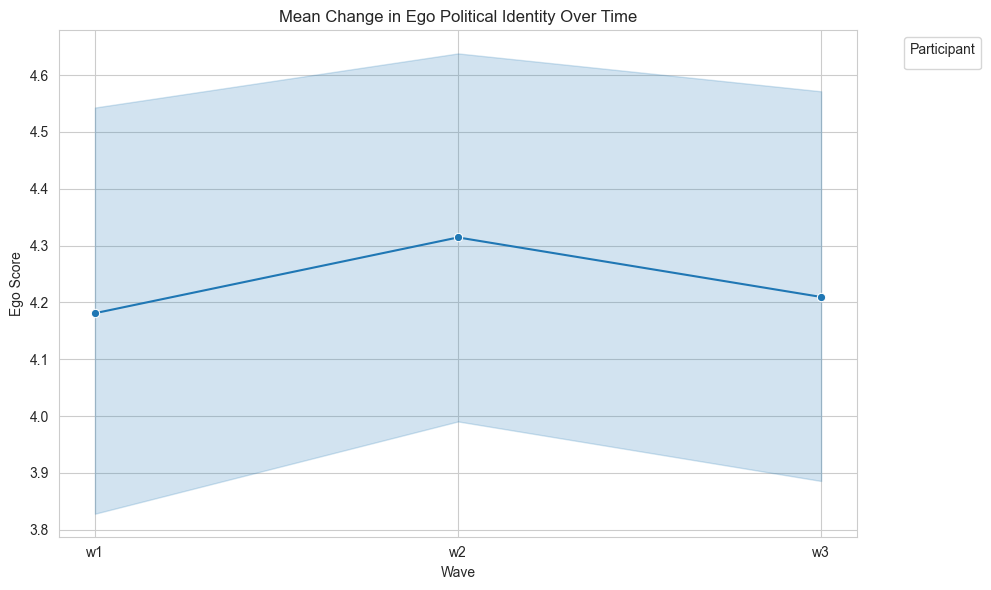

In [436]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='wave', y='ego_score', marker='o')
plt.title('Mean Change in Ego Political Identity Over Time')
plt.ylabel('Ego Score')
plt.xlabel('Wave')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')
plt.tight_layout()
plt.show()

In [437]:
print(df_ego_complete["w1"].mean())
print(df_ego_complete["w2"].mean())
print(df_ego_complete["w3"].mean())

4.180952380952381
4.314285714285714
4.20952380952381


/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_63113/2499831765.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('coolwarm').reversed()
/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_63113/2499831765.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')


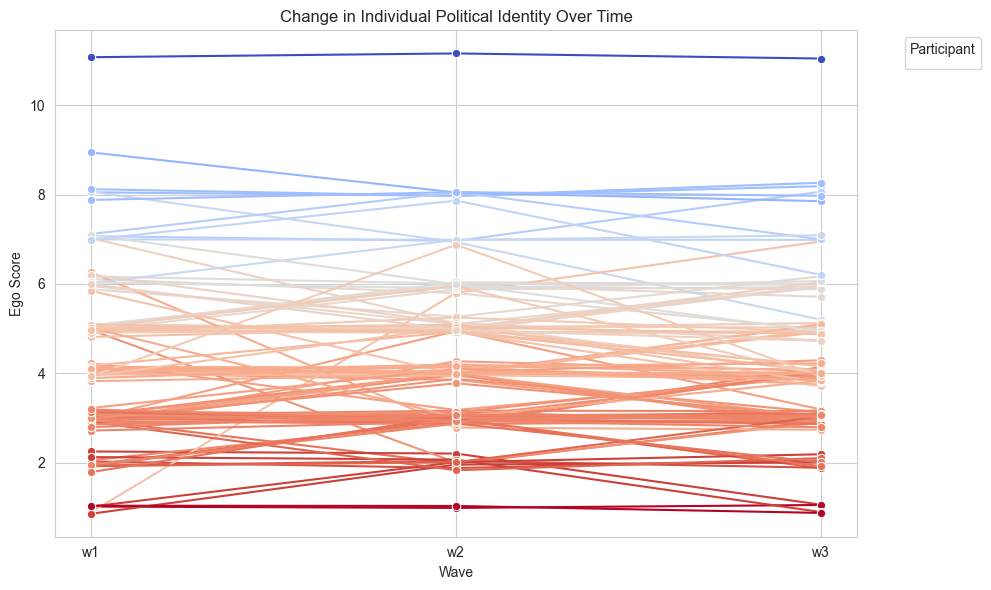

In [438]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

#### Step 1: Get average ego_score per participant!!!
participant_means = df_long.groupby('participant_id')['ego_score'].mean()

# Step 2: Normalize these scores
norm = Normalize(vmin=participant_means.min(), vmax=participant_means.max())

# Step 3: Get the colormap (blue-white-red)
cmap = get_cmap('coolwarm').reversed()

# Step 4: Map each participant to a color
participant_colors = {pid: cmap(norm(score)) for pid, score in participant_means.items()}

jitter_strength = 0.1
df_long['ego_jittered'] = df_long['ego_score'] + np.random.normal(0, jitter_strength, size=len(df_long))

# Step 5: Plot each line individually with its mapped color
plt.figure(figsize=(10, 6))
for pid, group in df_long.groupby('participant_id'):
    sns.lineplot(data=group, x='wave', y='ego_jittered', marker='o',
                 color=participant_colors[pid])

plt.title('Change in Individual Political Identity Over Time')
plt.ylabel('Ego Score')
plt.xlabel('Wave')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')
plt.tight_layout()
plt.show()


***

In [439]:
import pandas as pd

def political_identity_targeted(df):
    dict_political_identity = {}

    # First pass: build the base dictionary
    for index, row in df.iterrows():
        participant_id = row['participant.label']
        self_identity = row.get('network_app.1.player.linksrechts_self')

        if pd.isna(self_identity) or self_identity == 0:
            self_identity = float('nan')
        
        dict_political_identity[participant_id] = {
            'ego': self_identity,
            'alter': {}
        }

        for i in range(1, 30):
            other_identity = row.get(f'network_app.1.player.linksrechts_{i}')
            other_person = row.get(f'network_app.1.player.person_{i}')
            if pd.notna(other_identity) and other_identity != 0:
                dict_political_identity[participant_id]['alter'][other_person] = {
                    "given": other_identity,
                    "self": float('nan')
                }

    # Second pass: fill in 'self' for each alter using the alter's ego
    for participant_id, data in dict_political_identity.items():
        for alter_id in data['alter']:
            if alter_id in dict_political_identity:
                alter_ego = dict_political_identity[alter_id]['ego']
                data['alter'][alter_id]['self'] = alter_ego

    return dict_political_identity


In [440]:
dict_targeted_identity_w1 = political_identity_targeted(df_w1)
dict_targeted_identity_w2 = political_identity_targeted(df_w2)
dict_targeted_identity_w3 = political_identity_targeted(df_w3)

In [441]:
dict_targeted_identity_w1

{'wer': {'ego': nan, 'alter': {'poo': {'given': 6, 'self': nan}}},
 'ttz': {'ego': nan, 'alter': {'rte': {'given': 4, 'self': nan}}},
 'kru': {'ego': nan,
  'alter': {'bs3': {'given': 4, 'self': nan},
   'k4w': {'given': 4, 'self': nan}}},
 '4yx': {'ego': nan,
  'alter': {'kmw': {'given': 9, 'self': nan},
   'b3p': {'given': 3, 'self': nan},
   '9he': {'given': 3, 'self': nan}}},
 'qew': {'ego': 1,
  'alter': {'qew': {'given': 1, 'self': 1},
   '3ab': {'given': 3, 'self': nan},
   'rbb': {'given': 5, 'self': 5},
   'dxp': {'given': 4, 'self': 3},
   'tcc': {'given': 2, 'self': 3},
   'tdq': {'given': 5, 'self': 2},
   '3fv': {'given': 4, 'self': nan},
   'mw9': {'given': 4, 'self': 3}}},
 'k9w': {'ego': 5,
  'alter': {'k9w': {'given': 5, 'self': 5},
   'tuw': {'given': 3, 'self': 3},
   'ech': {'given': 6, 'self': 8},
   '39b': {'given': 5, 'self': 3},
   'ebs': {'given': 6, 'self': 4},
   'gdg': {'given': 3, 'self': 3},
   '4dk': {'given': 4, 'self': nan},
   'knc': {'given': 4, 'self

### Plot 1
- y-axe: Differenz (Wahrnehmung - Selbsteinstufung) 
- x-Axe: Selbsteinstufung


In [449]:
# Plot 1 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def flatten_identity_dict(dict_political_identity):
    rows = []

    for ego_id, values in dict_political_identity.items():
        ego_value = values['ego']
        for alter_id, alter_data in values['alter'].items():
            given = alter_data['given']
            if pd.notna(ego_value) and pd.notna(given):
                diff_percetion_self = (ego_value - given) 
                diff_other_self = (ego_value - alter_data['self'])
                rows.append({
                    'alter_id': alter_id,
                    'ego': ego_value,
                    'alter': alter_data['self'],
                    'alter_given': given,
                    'given_minus_self': diff_percetion_self,
                    'other_minus_self': diff_other_self,
                    'abs_given_minus_self': abs(diff_percetion_self),
                    'abs_other_minus_self': abs(diff_other_self)
                })

    return pd.DataFrame(rows)

long_df_w1 = flatten_identity_dict(dict_targeted_identity_w1)
long_df_w2 = flatten_identity_dict(dict_targeted_identity_w2)
long_df_w3 = flatten_identity_dict(dict_targeted_identity_w3)


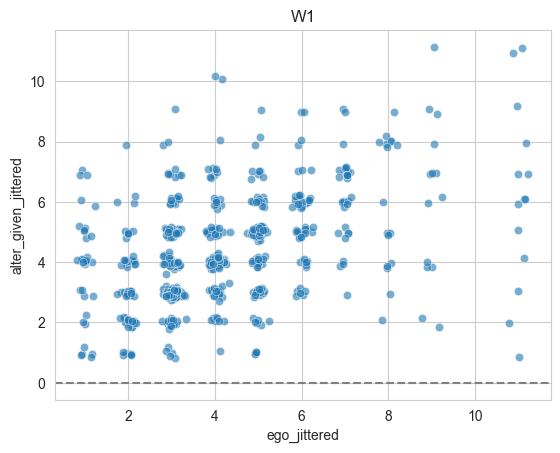

In [450]:
# Add jitter (small random noise) to the data
jitter_strength = 0.1
long_df_w1['ego_jittered'] = long_df_w1['ego'] + np.random.normal(0, jitter_strength, size=len(long_df_w1))
long_df_w1['alter_given_jittered'] = long_df_w1['alter_given'] + np.random.normal(0, jitter_strength, size=len(long_df_w1))

# Plot with jittered values
sns.scatterplot(
    data=long_df_w1,
    x="ego_jittered",
    y="alter_given_jittered",
    alpha=0.6
)
#plt.ylim([-11, 11])
#plt.xlim([0, 12])
plt.axhline(0, color='gray', linestyle='--')
#plt.xlabel("Self-Perception of Political Identity")
#plt.ylabel("External - SelfPerception")
plt.title("W1")
plt.savefig("/Users/ramius/Desktop/Results/P1_W1.png", dpi=300, bbox_inches='tight')
plt.show()

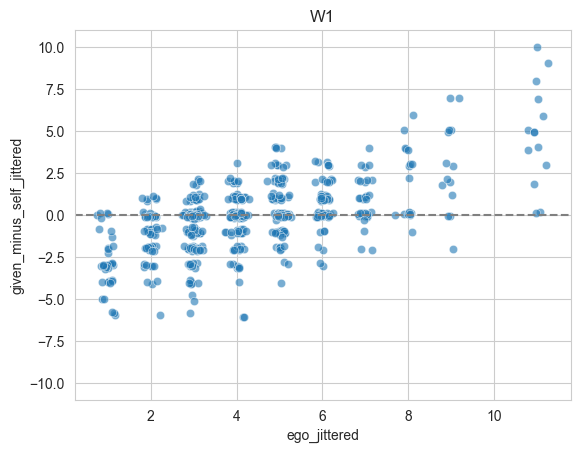

In [451]:
# Add jitter (small random noise) to the data
jitter_strength = 0.1
long_df_w1['ego_jittered'] = long_df_w1['ego'] + np.random.normal(0, jitter_strength, size=len(long_df_w1))
long_df_w1['given_minus_self_jittered'] = long_df_w1['given_minus_self'] + np.random.normal(0, jitter_strength, size=len(long_df_w1))

# Plot with jittered values
sns.scatterplot(
    data=long_df_w1,
    x="ego_jittered",
    y="given_minus_self_jittered",
    alpha=0.6
)
plt.ylim([-11, 11])
#plt.xlim([0, 12])
plt.axhline(0, color='gray', linestyle='--')
#plt.xlabel("Self-Perception of Political Identity")
#plt.ylabel("External - SelfPerception")
plt.title("W1")
plt.savefig("/Users/ramius/Desktop/Results/P1_W1.png", dpi=300, bbox_inches='tight')
plt.show()

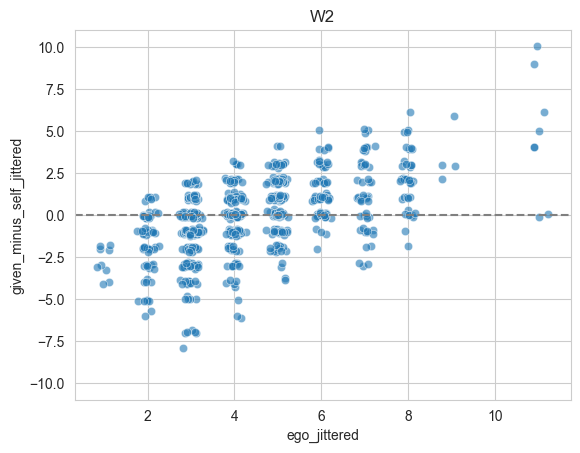

In [452]:
# Add jitter (small random noise) to the data
jitter_strength = 0.1
long_df_w2['ego_jittered'] = long_df_w2['ego'] + np.random.normal(0, jitter_strength, size=len(long_df_w2))
long_df_w2['given_minus_self_jittered'] = long_df_w2['given_minus_self'] + np.random.normal(0, jitter_strength, size=len(long_df_w2))

# Plot with jittered values
sns.scatterplot(
    data=long_df_w2,
    x="ego_jittered",
    y="given_minus_self_jittered",
    alpha=0.6
)
plt.axhline(0, color='gray', linestyle='--')
plt.ylim([-11, 11])
#plt.xlabel("Self-Perception of Political Identity")
#plt.ylabel("External - SelfPerception")
plt.title("W2")
plt.savefig("/Users/ramius/Desktop/Results/P1_W2.png", dpi=300, bbox_inches='tight')
plt.show()

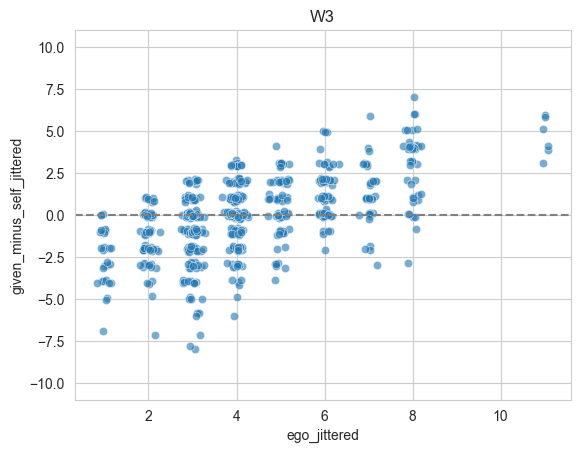

In [453]:
# Add jitter (small random noise) to the data
jitter_strength = 0.1
long_df_w3['ego_jittered'] = long_df_w3['ego'] + np.random.normal(0, jitter_strength, size=len(long_df_w3))
long_df_w3['given_minus_self_jittered'] = long_df_w3['given_minus_self'] + np.random.normal(0, jitter_strength, size=len(long_df_w3))

# Plot with jittered values
sns.scatterplot(
    data=long_df_w3,
    x="ego_jittered",
    y="given_minus_self_jittered",
    alpha=0.6
)
plt.axhline(0, color='gray', linestyle='--')
plt.ylim([-11, 11])
#plt.xlabel("Self-Perception of Political Identity")
#plt.ylabel("External - SelfPerception")
plt.title("W3")
plt.savefig("/Users/ramius/Desktop/Results/P1_W3.png", dpi=300, bbox_inches='tight')
plt.show()


## Second Plot
- y-axe: Differenz (Wahrnehmung - Selbsteinstufung)
- x-axe: Differenz zwischen Selbsteinstufung der Befragten und Selbsteinstufung des Targets

In [ ]:
long_df_w1

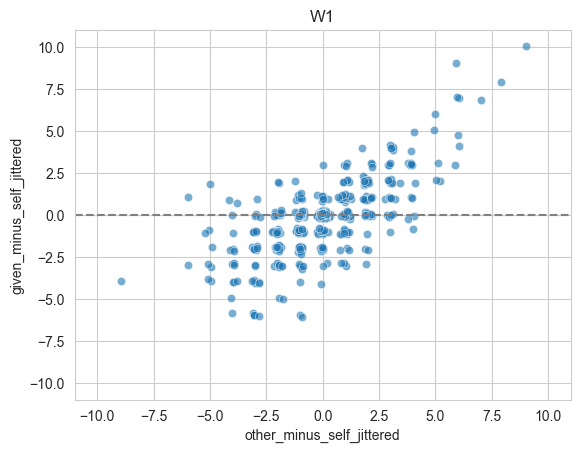

In [458]:
# Add jitter (small random noise) to the data
jitter_strength = 0.1
long_df_w1['given_minus_self_jittered'] = long_df_w1['given_minus_self'] + np.random.normal(0, jitter_strength, size=len(long_df_w1))
long_df_w1['other_minus_self_jittered'] = long_df_w1['other_minus_self'] + np.random.normal(0, jitter_strength, size=len(long_df_w1))

# Plot with jittered values
sns.scatterplot(
    data=long_df_w1,
    x="other_minus_self_jittered",
    y="given_minus_self_jittered",
    alpha=0.6
)
plt.axhline(0, color='gray', linestyle='--')
#plt.xlabel("Self-Perception - Other-Self-Perception")
#plt.ylabel("External - SelfPerception")
plt.ylim([-11, 11])
plt.xlim([-11, 11])
plt.title("W1")
plt.savefig("/Users/ramius/Desktop/Results/P2_W1.png", dpi=300, bbox_inches='tight')
plt.show()

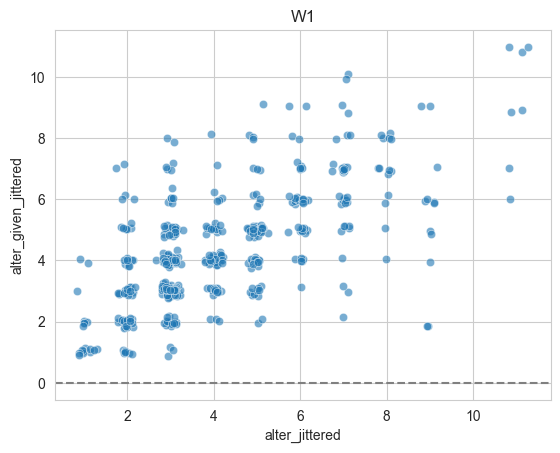

In [461]:
# Add jitter (small random noise) to the data
jitter_strength = 0.1
long_df_w1['alter_given_jittered'] = long_df_w1['alter_given'] + np.random.normal(0, jitter_strength, size=len(long_df_w1))
long_df_w1['alter_jittered'] = long_df_w1['alter'] + np.random.normal(0, jitter_strength, size=len(long_df_w1))

# Plot with jittered values
sns.scatterplot(
    data=long_df_w1,
    x="alter_jittered",
    y="alter_given_jittered",
    alpha=0.6
)
plt.axhline(0, color='gray', linestyle='--')
#plt.xlabel("Self-Perception - Other-Self-Perception")
#plt.ylabel("External - SelfPerception")
#plt.ylim([-11, 11])
#plt.xlim([-11, 11])
plt.title("W1")
plt.savefig("/Users/ramius/Desktop/Results/P2_W1.png", dpi=300, bbox_inches='tight')
plt.show()

In [455]:
# Add jitter (small random noise) to the data
jitter_strength = 0.1
long_df_w2['ego_jittered'] = long_df_w2['ego_minus_alterego'] + np.random.normal(0, jitter_strength, size=len(long_df_w2))
long_df_w2['ego_minus_given_jittered'] = long_df_w2['ego_minus_given'] + np.random.normal(0, jitter_strength, size=len(long_df_w2))

# Plot with jittered values
sns.scatterplot(
    data=long_df_w2,
    x="ego_jittered",
    y="ego_minus_given_jittered",
    alpha=0.6
)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Self-Perception - Other-Self-Perception")
plt.ylabel("External - SelfPerception")
plt.title("W2")
plt.savefig("/Users/ramius/Desktop/Results/P2_W2.png", dpi=300, bbox_inches='tight')
plt.show()

KeyError: 'ego_minus_alterego'

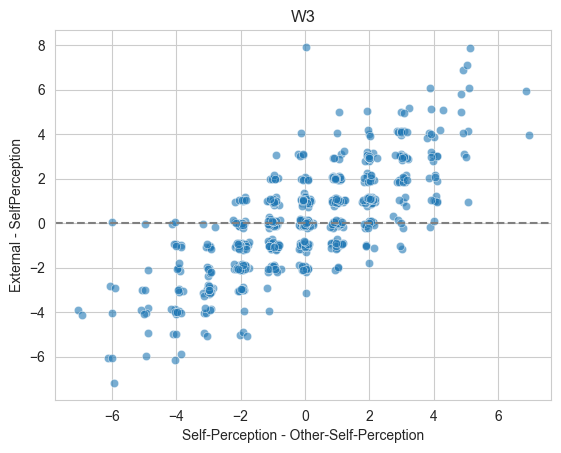

In [276]:
# Add jitter (small random noise) to the data
jitter_strength = 0.1
long_df_w3['ego_jittered'] = long_df_w3['ego_minus_alterego'] + np.random.normal(0, jitter_strength, size=len(long_df_w3))
long_df_w3['ego_minus_given_jittered'] = long_df_w3['ego_minus_given'] + np.random.normal(0, jitter_strength, size=len(long_df_w3))

# Plot with jittered values
sns.scatterplot(
    data=long_df_w3,
    x="ego_jittered",
    y="ego_minus_given_jittered",
    alpha=0.6
)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Self-Perception - Other-Self-Perception")
plt.ylabel("External - SelfPerception")
plt.title("W3")
plt.savefig("/Users/ramius/Desktop/Results/P2_W3.png", dpi=300, bbox_inches='tight')
plt.show()

***